# QR Code Library Comparison

### Install Requirements

In [81]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn
!pip install openpyxl
!pip install qreader
!pip install pyboof
!pip install dbr
!pip install matplotlib

### Import Required Libraries

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
import fiftyone as fo
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms
from IPython.display import display


### Specify Model

There are several output folders from training multiple models.  

In [4]:
# set this to today's date
today = "2024-03-15"

# modify output folder suffix if needed
suffix = "kfold_train"

# name of output folder
output_folder_name = today + "_" + suffix

data_path = '/home/jovyan/work/data/2024-03-14_leaves'
output_folder = f'/home/jovyan/work/mask_rcnn/{output_folder_name}'

k=5

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [ ]:
import numpy as np
from PIL import Image, ImageOps
import fiftyone as fo
import cv2
import subprocess
from qreader import QReader

def append_qr_to_filename(filename):
    root, ext = os.path.splitext(filename)
    return f"{root}_qr{ext}"


# Assuming leaf_predictor is defined elsewhere and dataset is an iterable of samples
datasets = {}
qreader = QReader()

for fold in range(0, 5):
    
    base_path = f"{output_folder}/fold_{fold}/"

    leaf_cfg = get_cfg()
    leaf_cfg.MODEL.DEVICE='cpu'
    leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
    leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

    leaf_predictor = DefaultPredictor(leaf_cfg)
    
    print(f'Loading fold {fold} into fiftyone dataset...')
    
    datasets[f'fold_{fold}'] = fo.Dataset.from_dir(
        data_path=f"{data_path}",
        labels_path=f"{output_folder}/test_{fold}.json",
        dataset_type=fo.types.COCODetectionDataset, 
        name=f"{today}_fold_{fold}",
        label_types="segmentations",
        overwrite=True
    )
    
    print(f'Performing inference for fold {fold}...')
    

    with fo.ProgressBar() as pb:
        for sample in pb(datasets[f'fold_{fold}']):
            image = Image.open(sample.filepath)
            image = ImageOps.exif_transpose(image)  # Ensure correct orientation
            image_arr = np.array(image)
            h, w, _ = image_arr.shape

            outputs = leaf_predictor(image_arr)
            pred_boxes = outputs['instances'].pred_boxes.tensor.numpy()
            class_labels = outputs['instances'].pred_classes.numpy()

            qr_indices = []
            leaf_indices = []
        
            # get indices of leaves and qr codes
            for i, label in enumerate(class_labels):
                 if label == 1: # qr
                    qr_indices.append(i)

            # if qr code was detected, decode
            crop_img = None
            qr_result_decoded = None

            if len(qr_indices):

                # get first qr code (assumes there is only 1 code per image)
                bbox = pred_boxes[qr_indices[0]]

                # (x0, y0, x1, y1)  Get bounds of QR code +-500px
                x0 = round(bbox[0].item()-500)
                y0 = round(bbox[1].item()-500)
                x1 = round(bbox[2].item()+500)
                y1 = round(bbox[3].item()+500)

                # crop to bounding box for QR decoding
                crop_img = image_arr[ y0:y1, x0:x1]

                scale_percent = 50 # percent of original size
                width = int(crop_img.shape[1] * scale_percent / 100)
                height = int(crop_img.shape[0] * scale_percent / 100)
                dim = (width, height)

                # resize image
                crop_img_resized = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)

                save_path = 'cropped_qr_codes/' + append_qr_to_filename(os.path.basename(sample.filepath))

                image_to_save = Image.fromarray(crop_img_resized)
                image_to_save.save(save_path)
                
                
                cmd = subprocess.run(
                    ["python", "decode_qr.py"],
                    capture_output=True,
                    check=False,
                    text=True
                )
                

In [116]:
import subprocess

# Directory containing images
image_folder = '/home/jovyan/work/data/2024-03-14_leaves'

# Run the script
!python decode_qr_codes.py {image_folder}


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
{'total_images': 638, 'pyzbar_success_percent': 52.66457680250783, 'opencv_success_percent': 3.918495297805643, 'qreader_success_percent': 78.0564263322884, 'pyboof_success_percent': 55.4858934169279}
Percentage of images with successful decoding: 83.07%
Figure(1000x600)


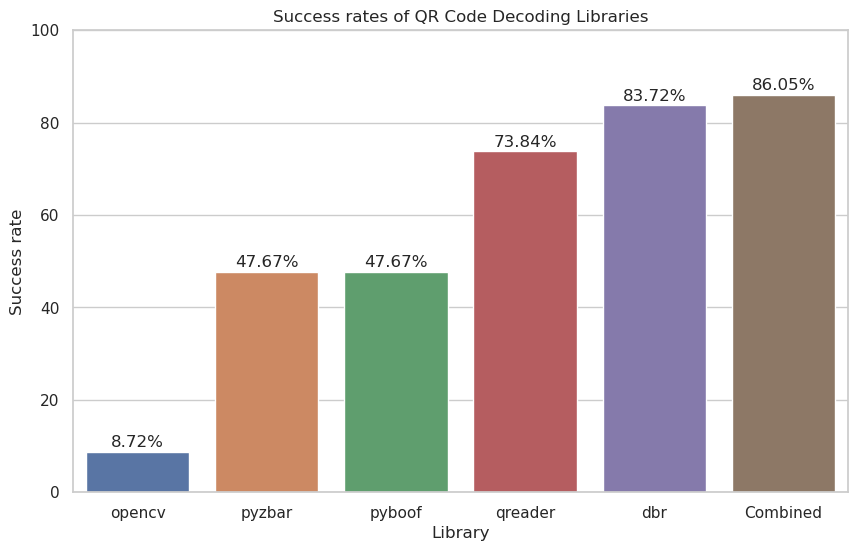

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('qr_code_results.csv')


# Calculate success percentages for each library
total_images = len(df)
libraries = [
    'pyzbar',
    'opencv',
    'qreader',
    'dbr',
    'pyboof'
]

success_percentages = {}

for library in libraries:
    success_count = df[library+'_result'].notna().sum()
    success_percentages[library] = (success_count / total_images) * 100

# Calculate overall success percentage
overall_success_percent = (df['success'].sum() / total_images) * 100

# Prepare the data for plotting
plot_data = pd.DataFrame(list(success_percentages.items()), columns=['library', 'success_percent'])

# Sort the plot data by success_percent
plot_data = plot_data.sort_values(by='success_percent')

# Add overall success percentage to the plot data
plot_data.loc[len(plot_data)] = ['Combined', overall_success_percent]

# Plot the data using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='library', y='success_percent', data=plot_data)

# Add percentage labels to the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 1, f'{height:.2f}%', ha='center')

plt.title('Success rates of QR Code Decoding Libraries')
plt.xlabel('Library')
plt.ylabel('Success rate')
plt.ylim(0, 100)
plt.savefig('free_qr_libraries.png')
plt.show()

